# Li-2015 - A DataJoint example
The data and results presented in this notebook pertain to the paper:

>Nuo Li, Tsai-Wen Chen, Zengcai V. Guo, Charles R. Gerfen & Karel Svoboda. "A motor cortex circuit for motor planning and movement" (2015) Nature (https://dx.doi.org/10.1038/nature14178)

This notebook provide demonstrations of working with a DataJoint data pipeline in querying data, apply data conditioning and reproduce some key figures in the paper. The orignal data , in NWB 2.0 format, had been ingested into a DataJoint data pipeline (data pipeline schema is given below). As a validation of complete ingestion of the original data into DataJoint, figures 2b, 2c, and extended figure 2 will be reproduced in this example.

In [1]:
%matplotlib inline
import os
os.chdir('..')

In [2]:
import datajoint as dj
dj.conn().connect()

Connecting root@127.0.0.1:3306


In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal

from pipeline import lab, experiment, ephys, psth
from pipeline.plot import unit_characteristic_plot, unit_psth

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Single unit PSTH - Figure 2b

#### We first select a set of sample neurons
#### Using the built-in `plot_unit_psth`, plots of spike-raster and unit PSTH can be produced based on the selected units

In [7]:
units = ephys.Unit & [{'subject_id': 218457, 'session': 4, 'unit': 11},
                      {'subject_id': 219248, 'session': 2, 'unit': 12},  
                      {'subject_id': 219037, 'session': 2, 'unit': 5},
                      {'subject_id': 219031, 'session': 2, 'unit': 17},
                      {'subject_id': 210862, 'session': 2, 'unit': 29},
                      {'subject_id': 210863, 'session': 2, 'unit': 10},
                      {'subject_id': 210863, 'session': 1, 'unit': 10},
                      {'subject_id': 219033, 'session': 5, 'unit': 1},
                      {'subject_id': 219036, 'session': 5, 'unit': 13}]

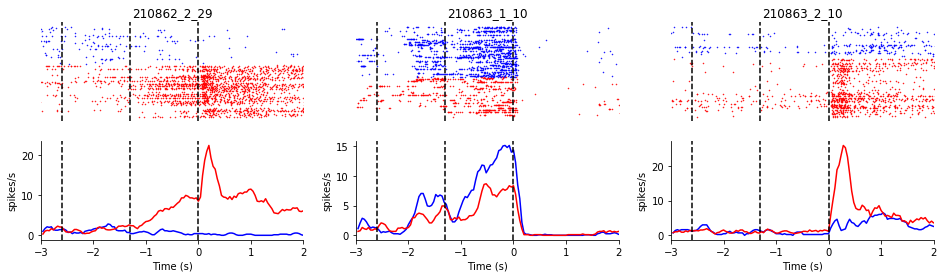

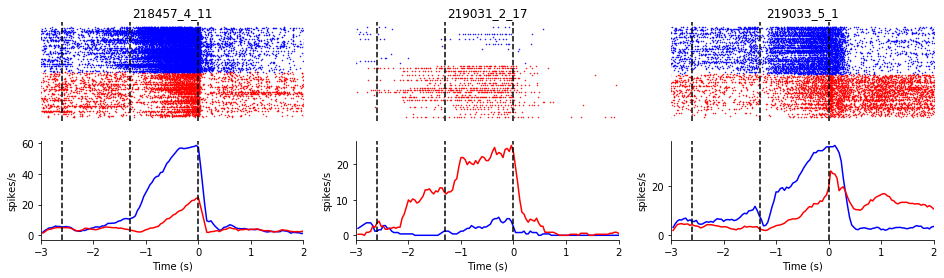

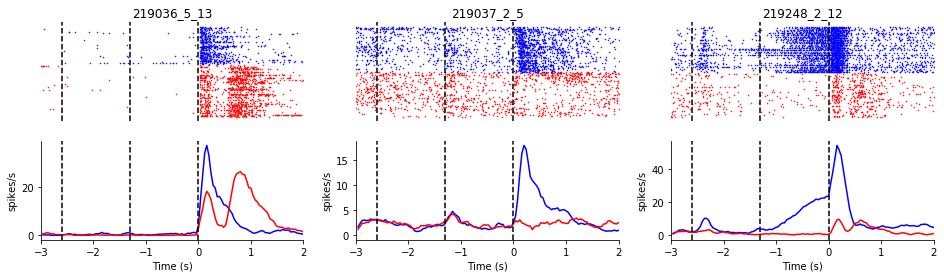

In [8]:
unit_keys = units.fetch('KEY')
ax_per_row = 3
for offset in np.arange(0, len(units), ax_per_row):
    fig, axes = plt.subplots(2, ax_per_row, figsize=(16, 4))
    for axs, u in zip(axes.T, unit_keys[offset: offset + ax_per_row]):
        unit_psth.plot_unit_psth(u, axs=axs,
                                 title='_'.join([str(u['subject_id']), str(u['session']), str(u['unit'])]))

## Single unit PSTH - Extended Data Figure 2
Similarly, for extended data Figure 2a - an extended set of neurons are selected here for the spike-raster and psth plots

In [139]:
units = ephys.Unit & [{'subject_id': 214430, 'session': 2, 'unit': 4},
                      {'subject_id': 218457, 'session': 1, 'unit': 1},
                      {'subject_id': 210863, 'session': 1, 'unit': 7},
                      {'subject_id': 219033, 'session': 4, 'unit': 5},
                      {'subject_id': 210862, 'session': 2, 'unit': 23},  
                      {'subject_id': 210861, 'session': 2, 'unit': 6},
                      {'subject_id': 210863, 'session': 1, 'unit': 11},
                      {'subject_id': 218457, 'session': 3, 'unit': 3},
                      {'subject_id': 219031, 'session': 5, 'unit': 3},
                      {'subject_id': 210863, 'session': 2, 'unit': 10},
                      {'subject_id': 219033, 'session': 3, 'unit': 5},
                      {'subject_id': 218457, 'session': 4, 'unit': 14},
                      {'subject_id': 219247, 'session': 1, 'unit': 4},
                      {'subject_id': 219248, 'session': 2, 'unit': 12},
                      {'subject_id': 210862, 'session': 2, 'unit': 4},                   
                      {'subject_id': 219248, 'session': 1, 'unit': 11},
                      {'subject_id': 219031, 'session': 5, 'unit': 4},
                      {'subject_id': 219031, 'session': 2, 'unit': 14},
                      {'subject_id': 210863, 'session': 3, 'unit': 34},
                      {'subject_id': 219030, 'session': 5, 'unit': 8}]

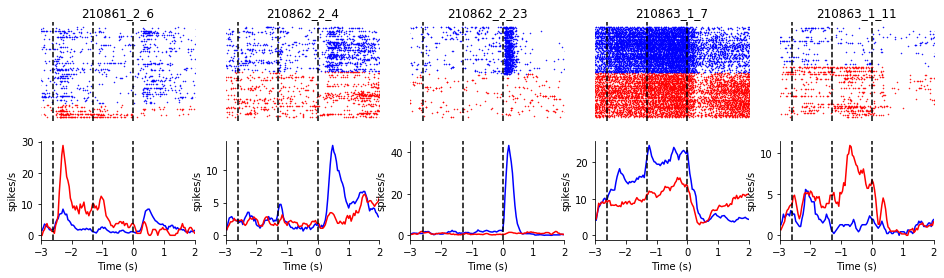

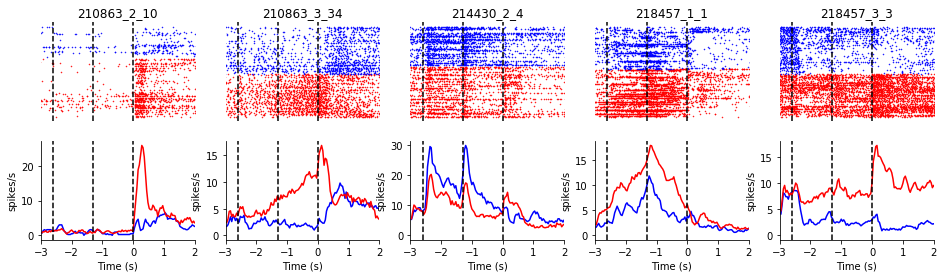

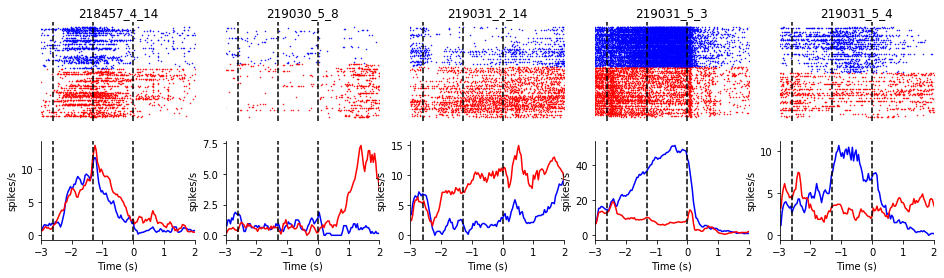

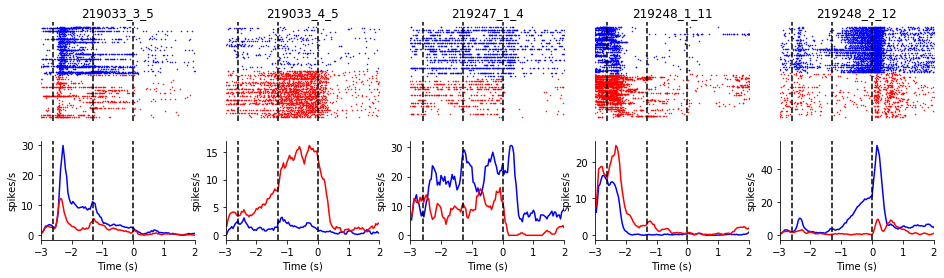

In [140]:
ax_per_row = 5
for offset in np.arange(0, len(units), ax_per_row):
    fig, axes = plt.subplots(2, ax_per_row, figsize=(16, 4))
    for axs, u in zip(axes.T, units.fetch('KEY', offset=offset, limit=ax_per_row)):
        unit_psth.plot_unit_psth(u, axs=axs,
                                 title='_'.join([str(u['subject_id']), str(u['session']), str(u['unit'])]))

## Group-level unit PSTH with selectivity - Figure 2c
Here, we select all units passing the restriction criteria:
+ located in left M2 area
+ `Pyramidal` cell type
+ only selective units

The units are sorted based on the center of gravity of the differences in PSTH between left/right trials for plotting

In [13]:
units = (ephys.Unit & (ephys.ProbeInsertion.InsertionLocation
                       * experiment.BrainLocation  & {'brain_area': 'M2', 'hemisphere': 'left'}))

In [14]:
units = units * ephys.UnitCellType * psth.UnitSelectivity & 'cell_type = "Pyr"' & 'unit_selectivity != "non-selective"'

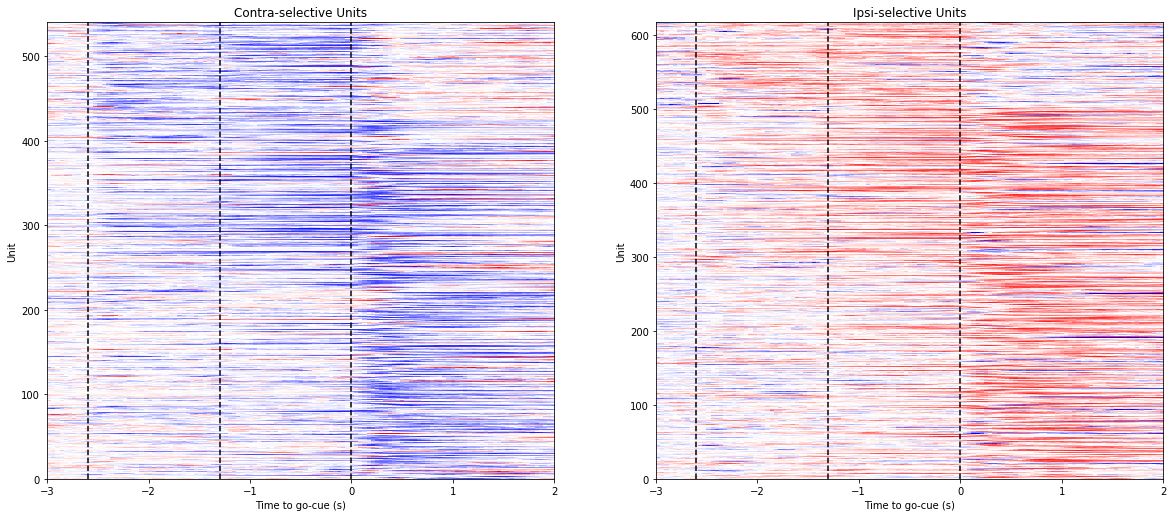

In [37]:
unit_characteristic_plot.plot_selectivity_sorted_stacked_contra_ipsi_psth(units)

#### From units, further select only units that are:
+ Selective during `sample` or `delay` period and not `response`

In [52]:
sample_delay_units = units & (psth.PeriodSelectivity
                              & 'period in ("sample", "delay")'
                              & 'period_selectivity != "non-selective"')
sample_delay_units = sample_delay_units & (psth.PeriodSelectivity
                                           & 'period = "response"'
                                           & 'period_selectivity = "non-selective"')

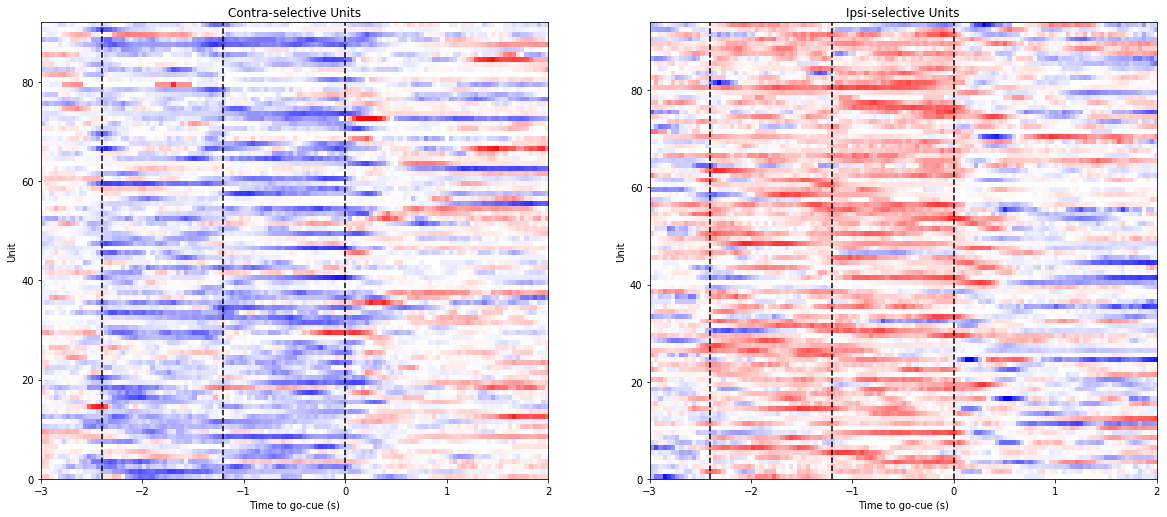

In [55]:
unit_characteristic_plot.plot_stacked_contra_ipsi_psth(sample_delay_units)

#### From units, further select only units that are:
+ Selective during `sample` or `delay` period and not `response`

In [75]:
sample_delay_response_units = units & (psth.PeriodSelectivity
                                       & 'period in ("sample", "delay")'
                                       & 'period_selectivity != "non-selective"')
sample_delay_response_units = sample_delay_response_units & (psth.PeriodSelectivity
                                                             & 'period = "response"'
                                                             & 'period_selectivity != "non-selective"')

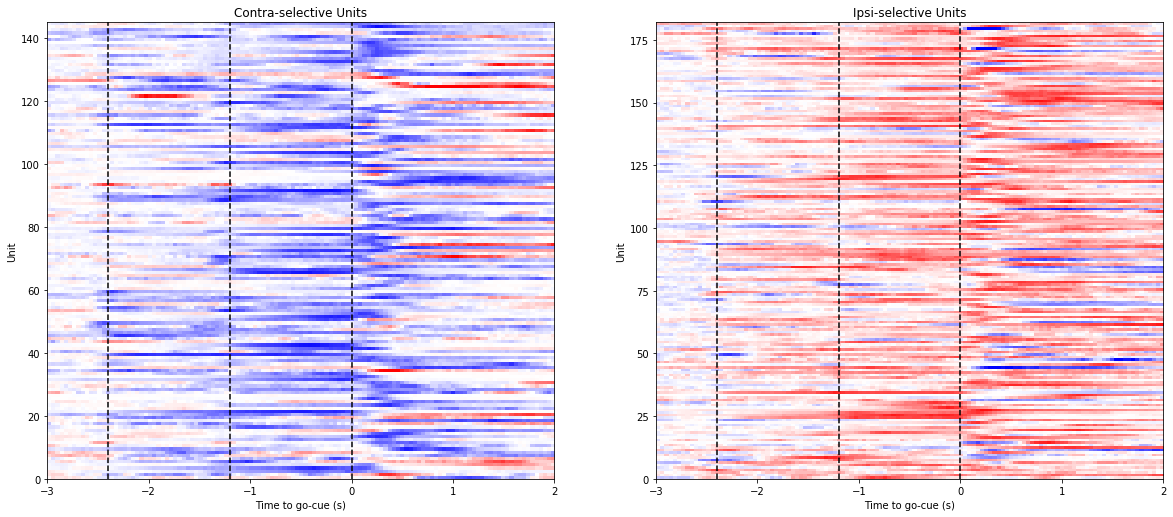

In [78]:
unit_characteristic_plot.plot_stacked_contra_ipsi_psth(sample_delay_response_units)

#### From units, further select only units that are:
+ Selective only during `response`period

In [79]:
response_units = units & (psth.PeriodSelectivity
                          & 'period in ("sample", "delay")'
                          & 'period_selectivity = "non-selective"')
response_units = response_units & (psth.PeriodSelectivity
                                   & 'period = "response"'
                                   & 'period_selectivity != "non-selective"')

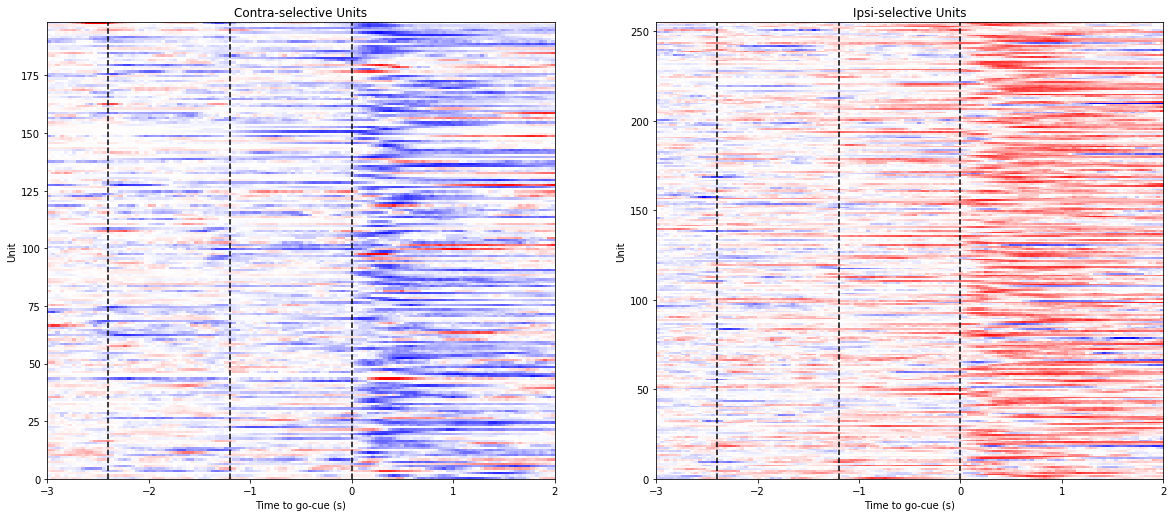

In [80]:
unit_characteristic_plot.plot_stacked_contra_ipsi_psth(response_units)

# ==================================================

In [36]:
import importlib
importlib.reload(unit_psth)
importlib.reload(unit_characteristic_plot)

<module 'pipeline.plot.unit_characteristic_plot' from 'C:\\Users\\thinh\\Documents\\TN-Vathes\\NWB_Janelia\\Li-2015a\\pipeline\\plot\\unit_characteristic_plot.py'>